<a href="https://colab.research.google.com/github/samahkareem/Deep-Learning-Models/blob/main/Copy_of_image_classification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.metrics import confusion_matrix

from tensorflow.keras import layers

from sklearn.metrics import classification_report







In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
img_height=180
img_width=180
batch_size=16
data_dir = '/content/drive/MyDrive/data/'
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='training',
    seed=42
)

# Convert TensorFlow tensors to NumPy arrays
x_train = []
y_train = []
for x, y in data:
    x_train.append(x.numpy())
    y_train.append(y.numpy())

x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

# Using ImageDataGenerator for preprocessing the data
datagen = ImageDataGenerator(rescale=1./255)

# Preprocess and augment the data using ImageDataGenerator
train_ds = datagen.flow(x_train, y_train, batch_size=batch_size)

# Load the validation dataset without augmentation
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Preprocess the validation data using ImageDataGenerator
x_val = []
y_val = []
for x, y in val_ds:
    x_val.append(x.numpy())
    y_val.append(y.numpy())

x_val = np.concatenate(x_val)
y_val = np.concatenate(y_val)

val_ds = datagen.flow(x_val, y_val, batch_size=16)


Found 1546 files belonging to 3 classes.
Using 1237 files for training.
Found 1546 files belonging to 3 classes.
Using 309 files for validation.


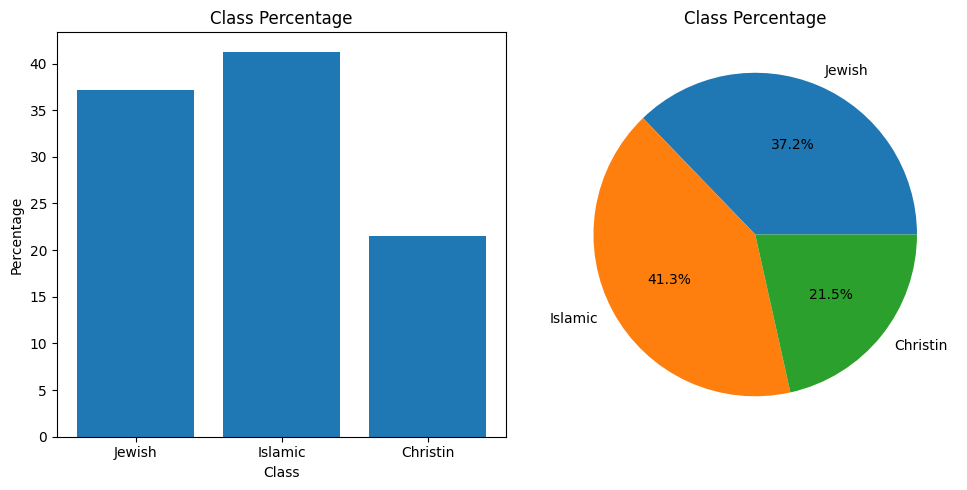

In [ ]:
import os
import matplotlib.pyplot as plt

# Directory where your data is located
data_dir = '/content/drive/MyDrive/data/'

# Get the class names
class_names = os.listdir(data_dir)

# Count the number of images in each class
class_counts = []
total_count = 0

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    image_count = len(os.listdir(class_dir))
    class_counts.append(image_count)
    total_count += image_count

# Calculate the class percentages
class_percentages = [count / total_count * 100 for count in class_counts]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the class percentages as a bar plot
ax1.bar(class_names, class_percentages)
ax1.set_xlabel('Class')
ax1.set_ylabel('Percentage')
ax1.set_title('Class Percentage')

# Plot the class percentages as a pie chart
ax2.pie(class_percentages, labels=class_names, autopct='%1.1f%%')
ax2.set_title('Class Percentage')

# Adjust spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()



Found 1546 files belonging to 3 classes.


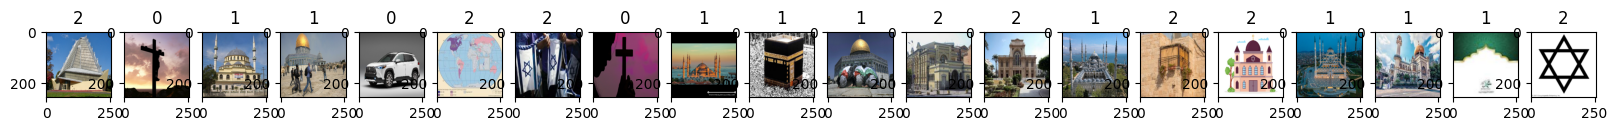

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/data/')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=20, figsize=(20,20))
for idx, img in enumerate(batch[0][:20]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:

num_classes=3
# Define the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 118336)            0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [ ]:


# Fitting the model
#history = model.fit(train_ds, validation_data=val_ds, epochs=7)


In [ ]:
# Define the callback function
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=3):
        super(EarlyStoppingCallback, self).__init__()
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print('Validation loss has not improved for {} epochs. Training stopped.'.format(self.patience))
                self.model.stop_training = True

# Create an instance of the callback
early_stopping = EarlyStoppingCallback(patience=3)

# Pass the callback to the model's fit function
history = model.fit(train_ds, validation_data=val_ds, epochs=7, callbacks=[early_stopping])

#history = model.fit(train_ds, validation_data=val_ds, epochs=7)


Epoch 1/7
78/78 [==============================] - 79s 989ms/step - loss: 1.3629 - accuracy: 0.4842 - val_loss: 0.9574 - val_accuracy: 0.5663
Epoch 2/7
78/78 [==============================] - 77s 996ms/step - loss: 0.8745 - accuracy: 0.6063 - val_loss: 0.8823 - val_accuracy: 0.6181
Epoch 3/7
78/78 [==============================] - 101s 1s/step - loss: 0.6208 - accuracy: 0.7478 - val_loss: 0.7518 - val_accuracy: 0.6958
Epoch 4/7
78/78 [==============================] - 91s 1s/step - loss: 0.3155 - accuracy: 0.8917 - val_loss: 0.8356 - val_accuracy: 0.6537
Epoch 5/7
78/78 [==============================] - 86s 1s/step - loss: 0.1292 - accuracy: 0.9677 - val_loss: 0.9653 - val_accuracy: 0.6764
Epoch 6/7
78/78 [==============================] - 82s 1s/step - loss: 0.0603 - accuracy: 0.9814 - val_loss: 1.2951 - val_accuracy: 0.6117


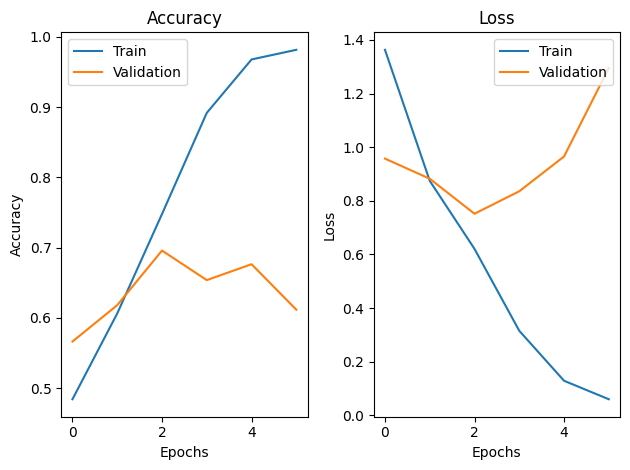

In [ ]:
# Plotting the accuracy and loss values
plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


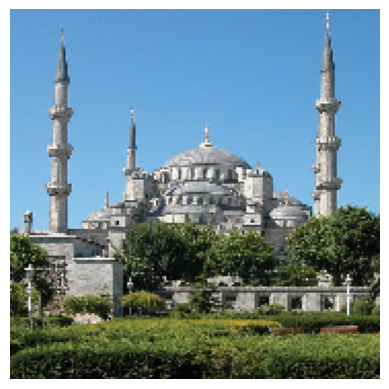

1/1 [==============================] - 0s 100ms/step
Predicted Class: Christian


In [ ]:


label_names = ['Islamic', 'Christian', 'Jewish']

# Load and display the image
image_path = '/content/drive/MyDrive/Sultan.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess the image for prediction
input_image = tf.keras.preprocessing.image.img_to_array(image)
input_image = np.expand_dims(input_image, axis=0)
input_image /= 255.0

# Make the prediction
predictions = model.predict(input_image)
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = label_names[predicted_class_index]

print('Predicted Class:', predicted_class_label)


In [ ]:
# Evaluate the model
evaluation = model.evaluate(val_ds)

# Print the evaluation results
print('Loss:', evaluation[0])
print('Accuracy:', evaluation[1])

20/20 [==============================] - 6s 318ms/step - loss: 1.2951 - accuracy: 0.6117
Loss: 1.295050024986267
Accuracy: 0.6116504669189453


Found 1546 files belonging to 3 classes.
Using 309 files for validation.
1/1 [==============================] - 0s 171ms/step
Classification Report:
              precision    recall  f1-score   support

     Islamic       0.33      0.75      0.45        60
   Christian       0.79      0.43      0.56       121
      Jewish       0.76      0.62      0.69       128

    accuracy                           0.57       309
   macro avg       0.63      0.60      0.57       309
weighted avg       0.69      0.57      0.59       309



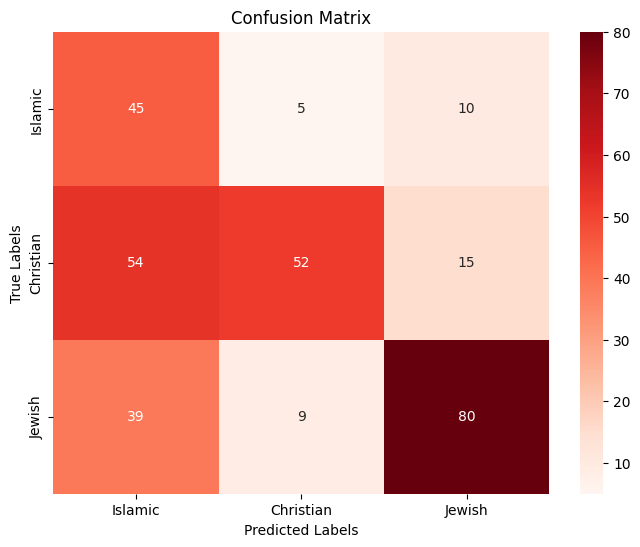

In [ ]:

# Load the evaluation dataset and true labels
evaluation_data = val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='validation',
    seed=42
)

true_labels = []
predicted_labels = []

# Iterate over the evaluation dataset and collect true labels and predicted labels
for images, labels in evaluation_data:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predicted_labels.extend(np.argmax(model.predict(images), axis=1))
    cr = classification_report(true_labels, predicted_labels, target_names=label_names)
print("Classification Report:")
print(cr)

# Convert the labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class labels
class_labels = ['Islamic', 'Christian', 'Jewish']

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
#Define Residual Neural Network Model(RNN)
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the Residual Block
def residual_block(inputs, filters, strides=1):
    # Shortcut path
    shortcut = inputs
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Shortcut connection
    if strides > 1:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Add shortcut and residual
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

# Define the ResNet model
def create_resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial convolutional layer
    x = Conv2D(62, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, filters=62)
    x = residual_block(x, filters=62)
    x = residual_block(x, filters=62)
    
    x = residual_block(x, filters=128, strides=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    
    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    
    x = residual_block(x, filters=512, strides=2)
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)
    
    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Define the input shape and number of classes
input_shape = (img_height, img_width, 3)
num_classes = len(label_names)

# Create the ResNet model
resnet_model = create_resnet_model(input_shape, num_classes)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

# Define the callback function
class EarlyStoppingCallback(Callback):
    def __init__(self, patience=3):
        super(EarlyStoppingCallback, self).__init__()
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print("Training stopped early due to no improvement in validation loss.")


In [ ]:
# Instantiate the callback
early_stopping = EarlyStoppingCallback(patience=3)

# Compile and fit the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_rnn = resnet_model.fit(train_ds, validation_data=val_ds, epochs=7, callbacks=[early_stopping])


Epoch 1/7
78/78 [==============================] - 621s 8s/step - loss: 1.4400 - accuracy: 0.3864 - val_loss: 2236.9858 - val_accuracy: 0.3689
Epoch 2/7
78/78 [==============================] - 598s 8s/step - loss: 1.0964 - accuracy: 0.4147 - val_loss: 768.9617 - val_accuracy: 0.1942
Epoch 3/7
78/78 [==============================] - 595s 8s/step - loss: 1.0612 - accuracy: 0.4503 - val_loss: 22.0627 - val_accuracy: 0.4142
Epoch 4/7
78/78 [==============================] - 592s 8s/step - loss: 1.0463 - accuracy: 0.4608 - val_loss: 1851.8556 - val_accuracy: 0.3916
Epoch 5/7
78/78 [==============================] - 597s 8s/step - loss: 1.0320 - accuracy: 0.4737 - val_loss: 3653.4126 - val_accuracy: 0.1942
Epoch 6/7
78/78 [==============================] - 596s 8s/step - loss: 1.0115 - accuracy: 0.5036 - val_loss: 233.2608 - val_accuracy: 0.3916


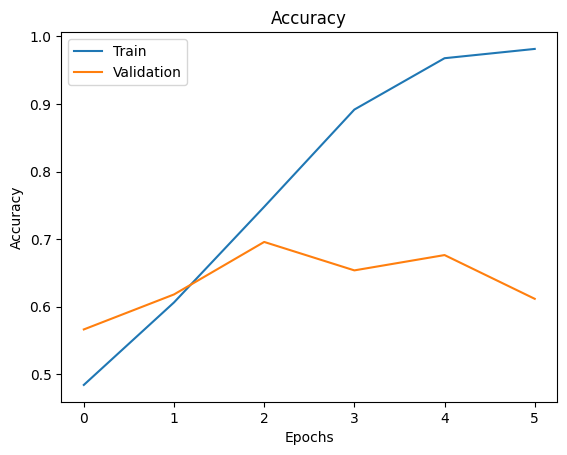

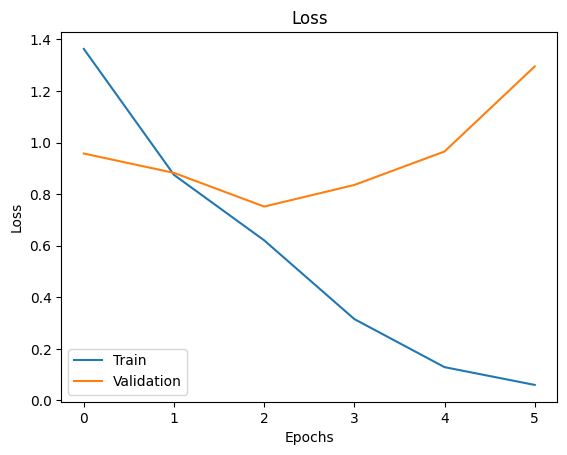

In [ ]:
import matplotlib.pyplot as plt

# Fitting the ResNet model
#history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plotting the loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [ ]:
# Evaluate the model
evaluation = model.evaluate(val_ds)

# Print the evaluation results
print('Loss:', evaluation[0])
print('Accuracy:', evaluation[1])

20/20 [==============================] - 7s 290ms/step - loss: 295.8252 - accuracy: 0.5728
Loss: 295.8251953125
Accuracy: 0.5728155374526978


Found 1546 files belonging to 3 classes.
Using 309 files for validation.
1/1 [==============================] - 0s 87ms/step
Classification Report:
              precision    recall  f1-score   support

     Islamic       0.33      0.75      0.45        60
   Christian       0.79      0.43      0.56       121
      Jewish       0.76      0.62      0.69       128

    accuracy                           0.57       309
   macro avg       0.63      0.60      0.57       309
weighted avg       0.69      0.57      0.59       309



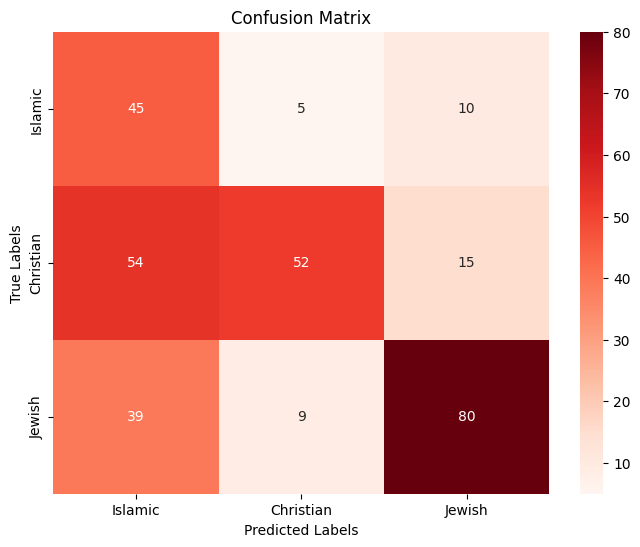

In [ ]:

# Load the evaluation dataset and true labels
evaluation_data = val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='validation',
    seed=42
)

true_labels = []
predicted_labels = []

# Iterate over the evaluation dataset and collect true labels and predicted labels
for images, labels in evaluation_data:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predicted_labels.extend(np.argmax(model.predict(images), axis=1))
    cr = classification_report(true_labels, predicted_labels, target_names=label_names)
print("Classification Report:")
print(cr)

# Convert the labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class labels
class_labels = ['Islamic', 'Christian', 'Jewish']

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense ,Reshape
from sklearn.preprocessing import LabelBinarizer

# Directory where your data is located
data_dir = '/content/drive/MyDrive/data/'

# Parameters
img_height = 180
img_width = 180
num_channels = 3  # Assuming RGB images
batch_size = 32

# Using ImageDataGenerator for loading and preprocessing the data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Loading the data from the directories
train_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Getting the number of classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(train_ds.classes)
num_classes = len(label_binarizer.classes_)

# Defining the model and its layers
model = Sequential([
    Reshape((img_height, img_width * num_channels), input_shape=(img_height, img_width, num_channels)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(num_classes, activation='softmax')
])

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
history_lstm = model.fit(train_ds, validation_data=val_ds, epochs=7)


Found 1238 images belonging to 3 classes.
Found 308 images belonging to 3 classes.
Epoch 1/7
33/39 [========================>.....] - ETA: 9s - loss: 1.0760 - accuracy: 0.4178 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


39/39 [==============================] - 85s 2s/step - loss: 1.0663 - accuracy: 0.4233 - val_loss: 1.0622 - val_accuracy: 0.4675
Epoch 2/7
39/39 [==============================] - 77s 2s/step - loss: 1.0155 - accuracy: 0.4580 - val_loss: 1.0649 - val_accuracy: 0.4578
Epoch 3/7
39/39 [==============================] - 77s 2s/step - loss: 1.0094 - accuracy: 0.4863 - val_loss: 1.0572 - val_accuracy: 0.4610
Epoch 4/7
39/39 [==============================] - 74s 2s/step - loss: 1.0014 - accuracy: 0.4733 - val_loss: 1.0479 - val_accuracy: 0.4481
Epoch 5/7
39/39 [==============================] - 75s 2s/step - loss: 0.9793 - accuracy: 0.5194 - val_loss: 1.0864 - val_accuracy: 0.4545
Epoch 6/7
39/39 [==============================] - 75s 2s/step - loss: 0.9899 - accuracy: 0.5113 - val_loss: 1.0518 - val_accuracy: 0.4545
Epoch 7/7
39/39 [==============================] - 78s 2s/step - loss: 0.9628 - accuracy: 0.5210 - val_loss: 1.0466 - val_accuracy: 0.4870


In [ ]:
# Evaluate the model
evaluation = model.evaluate(val_ds)

# Print the evaluation results
print('Loss:', evaluation[0])
print('Accuracy:', evaluation[1])

10/10 [==============================] - 15s 2s/step - loss: 1.0466 - accuracy: 0.4870
Loss: 1.0466463565826416
Accuracy: 0.48701298236846924


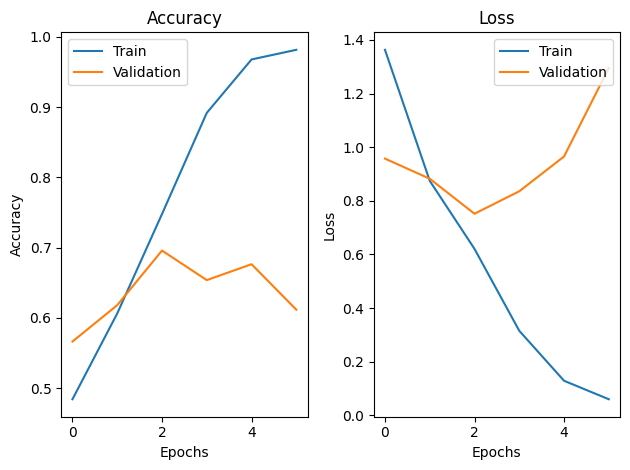

In [ ]:
# Plotting the accuracy and loss values
plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


Found 1546 files belonging to 3 classes.
Using 309 files for validation.
1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 205ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 207ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step
Classification Report:
              precision    recall  f1-score   support

     Islamic       0.38      0.25      0.30        60
   Christian       1.00      0.01      0.02       121
      Jewish       0.42      0.88      0.57       128

    accuracy                           0.42       309
   macro avg       0.60      0.38      0.30       309
weighted avg       0.64      0.42      0.30       309



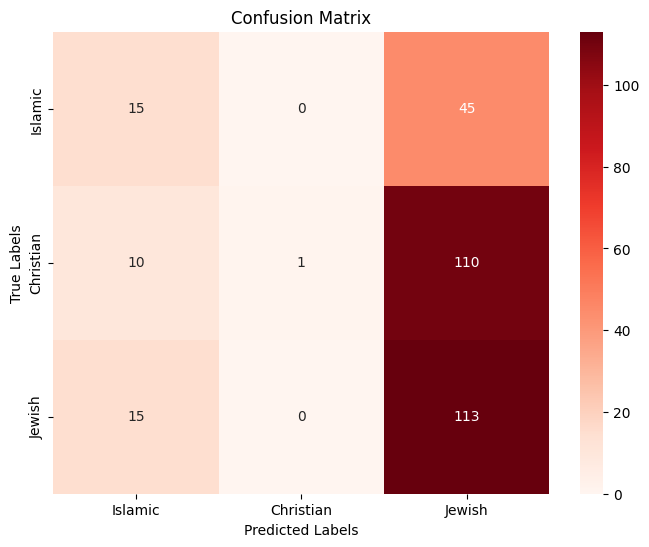

In [ ]:

# Load the evaluation dataset and true labels
evaluation_data = val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='validation',
    seed=42
)

true_labels = []
predicted_labels = []

# Iterate over the evaluation dataset and collect true labels and predicted labels
for images, labels in evaluation_data:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predicted_labels.extend(np.argmax(model.predict(images), axis=1))
    cr = classification_report(true_labels, predicted_labels, target_names=label_names)
print("Classification Report:")
print(cr)

# Convert the labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class labels
class_labels = ['Islamic', 'Christian', 'Jewish']

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


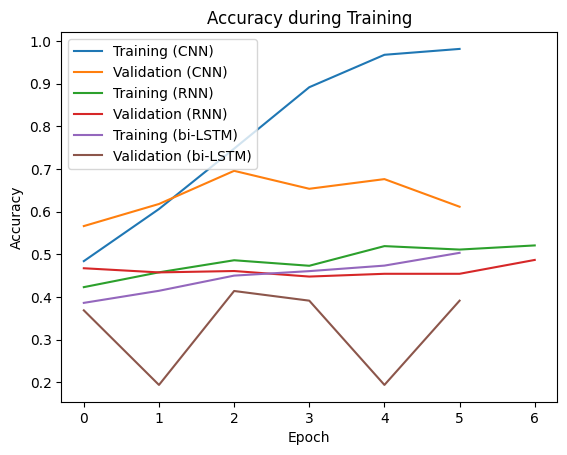

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training (CNN)', 'Validation (CNN)', 'Training (RNN)', 'Validation (RNN)','Training (bi-LSTM)', 'Validation (bi-LSTM)'], loc='upper left')
plt.title('Accuracy during Training')
plt.show()


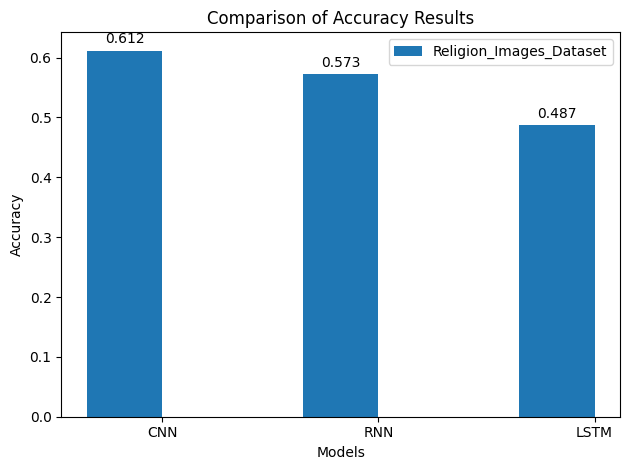

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Accuracy results for ASAD dataset
asad_acc = [0.6116504669189453,0.5728155374526978, 0.48701298236846924]


# Models
models = ['CNN','RNN','LSTM' ]

# Setting the width of each bar
bar_width = 0.35

# Creating the figure and axes
fig, ax = plt.subplots()

# Generating the x-axis positions
Reg_images= np.arange(len(models))


# Plotting the bars
rects1 = ax.bar(Reg_images, asad_acc, bar_width, label='Religion_Images_Dataset')


# Adding labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Accuracy Results')
ax.set_xticks(Reg_images + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

# Adding value labels to each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)


# Displaying the chart
plt.tight_layout()
plt.show()

